# Bank data 

Dataset: bank  
predictor : y (1, 0)   
The classification goal is to predict whether the client will take (1/0)  a term deposit ( our variable y is binary).
categorical : 10   
float :5   
int : 4  

## Univariate analyses
first run the univariate analyses (i.e., relation of the outcome with each predictor, one at a time) and then use only those variables which meet a preset cutoff for significance to run a multivariable model. 


In [2]:
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
df=pd.read_csv('../classification/banking.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp_var_rate    41188 non-null  float64
 16  cons_price_idx  41188 non-null  float64
 17  cons_conf_idx   41188 non-null 

# EDA on categorical

counting the difference between the outcome for each category.  
we normalize each category to observe the ratio of default to non default  

Observation:

Features that are most likely to subscribe:
1. job (student)
2. education (iliterate)
3. default (no)
4. contact  (celular)
5. Month (march, dec, sept, oct)
6. poutcome(success)

Requires some cleaning

In [4]:
cat_features=df.select_dtypes('object').columns
cat_features

Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome'], dtype='object')

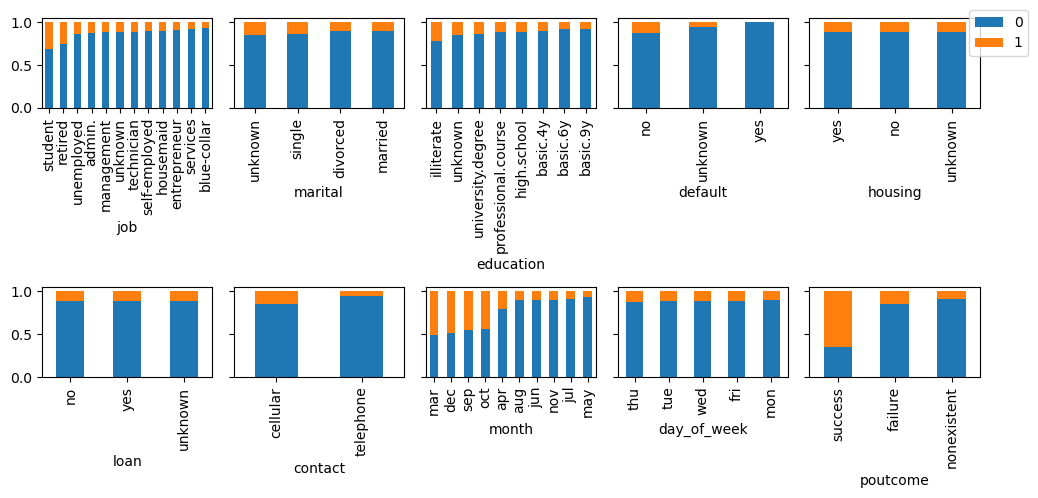

In [5]:
fig,axes=plt.subplots(nrows=2, ncols=5, figsize=(10,5),sharex=False, sharey=True)
for i,ax in enumerate(fig.axes):

    pd.crosstab(df[cat_features[i]],df.y, normalize='index').sort_values(by=1,ascending=False).plot.bar( stacked=True,ax=ax)
    ax.get_legend().remove()
    # or equivalently 
    #df.groupby(['y', 'job'])[['job']].count().unstack().fillna(0)
handles, labels= axes[0][0].get_legend_handles_labels()
fig.legend(handles,labels, bbox_to_anchor=(1.04,1))
plt.tight_layout()

### Using a contigency table, we calculate correlation of categorical data to Y

Assumption(H0): The categorical variable to predictors are not correlated.  

H1: The two columns are correlated. 

Result of Chi-Sq Test: The Probability of H0 being True

https://mlexplained.blog/2023/01/23/how-to-calculate-correlation-among-categorical-variables/

we see that housing and loan has no correlation to y variable. this is also shown in previous bar chart.

In [6]:
from scipy.stats import chi2_contingency

In [7]:
cat_summary=pd.DataFrame (index=[cat_features], columns=['p-value', 'decision'])
for cat_ in cat_features:
    #print (cat_)
    cross_tab_=pd.crosstab(df[cat_],df['y'])
    chi_sq_result = chi2_contingency(cross_tab_,)
    p, x = chi_sq_result[1], "REJECT" if chi_sq_result[1] < 0.05 else "ACCEPT"
    cat_summary.loc[cat_,'p-value']=np.round(p,4)
    cat_summary.loc[cat_,'decision']=x
    #print(f"The p-value is {chi_sq_result[1]:0.4f} and hence we {x} the null Hpothesis with {chi_sq_result[2]} degrees of freedom\n")

cat_summary

,p-value,decision
job,0.0,REJECT
marital,0.0,REJECT
education,0.0,REJECT
default,0.0,REJECT
housing,0.0583,ACCEPT
loan,0.5787,ACCEPT
contact,0.0,REJECT
month,0.0,REJECT
day_of_week,0.0,REJECT
poutcome,0.0,REJECT


In [8]:
# double check loan
cross_tab_=pd.crosstab(df['loan'],df['y'])
cross_tab_


y,0,1
loan,,
no,30100,3850
unknown,883,107
yes,5565,683


In [9]:
#clean basic education, jobs
#basic and hischool together as basic, illiterate and unknown, university and professional
education_list=[ 'illiterate', 'university','basic',] #,1,2,3
education_group=((df.education.isin(['illiterate'])),
                (df.education.str.contains('university|professional')),
                (df.education.str.contains('basic|high')))

df['education_1']=np.select(education_group,education_list, default='unknown')

#'student','retired','unemployed'=unemployed
#self_employed, entrepreneur =self_employed
#housemaid, services,
#technician, blue collar
#admin, management
job_list=['unemployed','self_employed','services','blue_collar','management']
job_group=((df.job.isin(['student','retired','unemployed'])),
            (df.job.isin(['self_employed','entrepreneur'])),
           (df.job.isin(['housemaid','services'])),
           (df.job.isin(['technician','blue-collar'])),
           (df.job.isin(['admin.','management']))
)

df['job_1']=np.select(job_group,job_list, default='unknown')
           
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y,education_1,job_1
0,44,blue-collar,married,basic.4y,unknown,yes,no,cellular,aug,thu,210,1,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1,0,basic,blue_collar
1,53,technician,married,unknown,no,no,no,cellular,nov,fri,138,1,999,0,nonexistent,-0.1,93.200,-42.0,4.021,5195.8,0,unknown,blue_collar
2,28,management,single,university.degree,no,yes,no,cellular,jun,thu,339,3,6,2,success,-1.7,94.055,-39.8,0.729,4991.6,1,university,management
3,39,services,married,high.school,no,no,no,cellular,apr,fri,185,2,999,0,nonexistent,-1.8,93.075,-47.1,1.405,5099.1,0,basic,services
4,55,retired,married,basic.4y,no,yes,no,cellular,aug,fri,137,1,3,1,success,-2.9,92.201,-31.4,0.869,5076.2,1,basic,unemployed


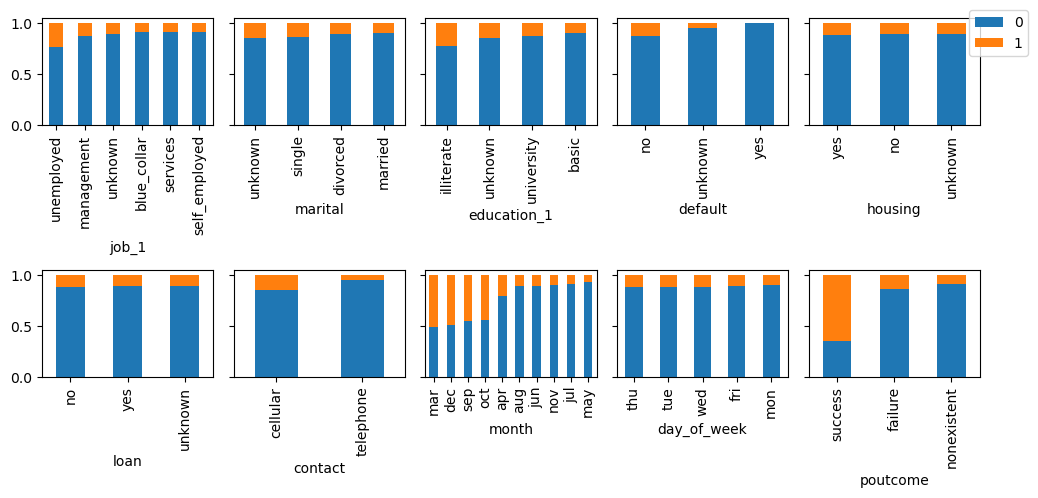

In [10]:
cat_features2=['job_1', 'marital', 'education_1', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']
fig,axes=plt.subplots(nrows=2, ncols=5, figsize=(10,5),sharex=False, sharey=True)
for i,ax in enumerate(fig.axes):

    pd.crosstab(df[cat_features2[i]],df.y, normalize='index').sort_values(by=1,ascending=False).plot.bar( stacked=True,ax=ax)
    ax.get_legend().remove()
    # or equivalently 
    #df.groupby(['y', 'job'])[['job']].count().unstack().fillna(0)
handles, labels= axes[0][0].get_legend_handles_labels()
fig.legend(handles,labels, bbox_to_anchor=(1.04,1))
plt.tight_layout()
# noticed majority of default yes= label 0 so this datapoint speaks for it self, if customer is default it automatically does not qualify for a new loan. 
# we can remove default data point entirely

In [11]:
cat_summary2=pd.DataFrame (index=[cat_features2], columns=['p-value', 'decision'])
for cat_ in cat_features2:
    #print (cat_)
    cross_tab_=pd.crosstab(df[cat_],df['y'])
    chi_sq_result = chi2_contingency(cross_tab_,)
    p, x = chi_sq_result[1], "REJECT" if chi_sq_result[1] < 0.05 else "ACCEPT"
    cat_summary2.loc[cat_,'p-value']=np.round(p,4)
    cat_summary2.loc[cat_,'decision']=x
    #print(f"The p-value is {chi_sq_result[1]:0.4f} and hence we {x} the null Hpothesis with {chi_sq_result[2]} degrees of freedom\n")

cat_summary2

,p-value,decision
job_1,0.0,REJECT
marital,0.0,REJECT
education_1,0.0,REJECT
default,0.0,REJECT
housing,0.0583,ACCEPT
loan,0.5787,ACCEPT
contact,0.0,REJECT
month,0.0,REJECT
day_of_week,0.0,REJECT
poutcome,0.0,REJECT


In [12]:
cat_features2

['job_1',
 'marital',
 'education_1',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'day_of_week',
 'poutcome']

In [13]:
#remove housing and day_of_week given they're all the same despite significance
cat_features2.remove('housing') #remove housing because it seems to have correlation to loan
cat_features2.remove('day_of_week') 
cat_features2


['job_1',
 'marital',
 'education_1',
 'default',
 'loan',
 'contact',
 'month',
 'poutcome']

# EDA continuous variables

Eyeball most distinct features are:
1. duration
2. previous
3. emp_var_rate

we use the 2 sample test to measure how different the continuous variables are with subscribers and non subscribers.
If a regressor is the same for the two type of subscribers then they are not a good predictor for subscriber/non subscriber.
The donwside,   an error of false positive increases according to the number of predictors. there are only 10 features, 5% error rate is still less than 1. I'll take the chance.



In [14]:
float_features=df.select_dtypes(exclude='object').columns.to_list()

df.select_dtypes(exclude='object').groupby ('y').describe()

age                                                     duration                                                             campaign                                                  pdays                                                          previous                                              emp_var_rate                                              cons_price_idx                                                              cons_conf_idx                                                    euribor3m                                                        nr_employed                                                                
     count       mean        std   min   25%   50%   75%   max    count        mean         std   min    25%    50%     75%     max    count      mean       std  min  25%  50%  75%   max    count        mean         std  min    25%    50%    75%    max    count      mean       std  min  25%  50%  75%  max        count      mean       std  min  25%  50%  75%  max          count       mean       std     min     25%     50%     75%     max         count       mean       std   min   25%   50%   75%   max     count      mean       std    min    25%    50%    75%    max       count         mean        std     min     25%     50%     75%     max
y                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     
0  36548.0  39.911185   9.898132  17.0  32.0  38.0  47.0  95.0  36548.0  220.844807  207.096293   0.0   95.0  163.5  279.00  4918.0  36548.0  2.633085  2.873438  1.0  1.0  2.0  3.0  56.0  36548.0  984.113878  120.656868  0.0  999.0  999.0  999.0  999.0  36548.0  0.132374  0.409199  0.0  0.0  0.0  0.0  7.0      36548.0  0.248875  1.482932 -3.4 -1.8  1.1  1.4  1.4        36548.0  93.603757  0.558993  92.201  93.075  93.918  93.994  94.767       36548.0 -40.593097  4.391155 -50.8 -42.7 -41.8 -36.4 -26.9   36548.0  3.811491  1.638187  0.634  1.405  4.857  4.962  5.045     36548.0  5176.166600  64.571979  4963.6  5099.1  5195.8  5228.1  5228.1
1   4640.0  40.913147  13.837476  17.0  31.0  37.0  50.0  98.0   4640.0  553.191164  401.171871  37.0  253.0  449.0  741.25  4199.0   4640.0  2.051724  1.666245  1.0  1.0  2.0  2.0  23.0   4640.0  792.035560  403.407181  0.0  999.0  999.0  999.0  999.0   4640.0  0.492672  0.860344  0.0  0.0  0.0  1.0  6.0       4640.0 -1.233448  1.623626 -3.4 -1.8 -1.8 -0.1  1.4         4640.0  93.354386  0.676644  92.201  92.893  93.200  93.918  94.767        4640.0 -39.789784  6.139668 -50.8 -46.2 -40.4 -36.1 -26.9    4640.0  2.123135  1.742598  0.634  0.849  1.266  4.406  5.045      4640.0  5095.115991  87.572641  4963.6  5017.5  5099.1  5191.0  5228.1

In [15]:
for_hist_plotting= pd.melt(df.loc[:, float_features], id_vars='y', value_vars=float_features[:-1])


We first check wheather our continous variables are indeed continuous. 

we look for :
values that can be made into categorical:
cons_conf_idx, group by buckets.  
I'm not sure what p_days are and it seemed to be skew to 999. change to 0 and 1


''

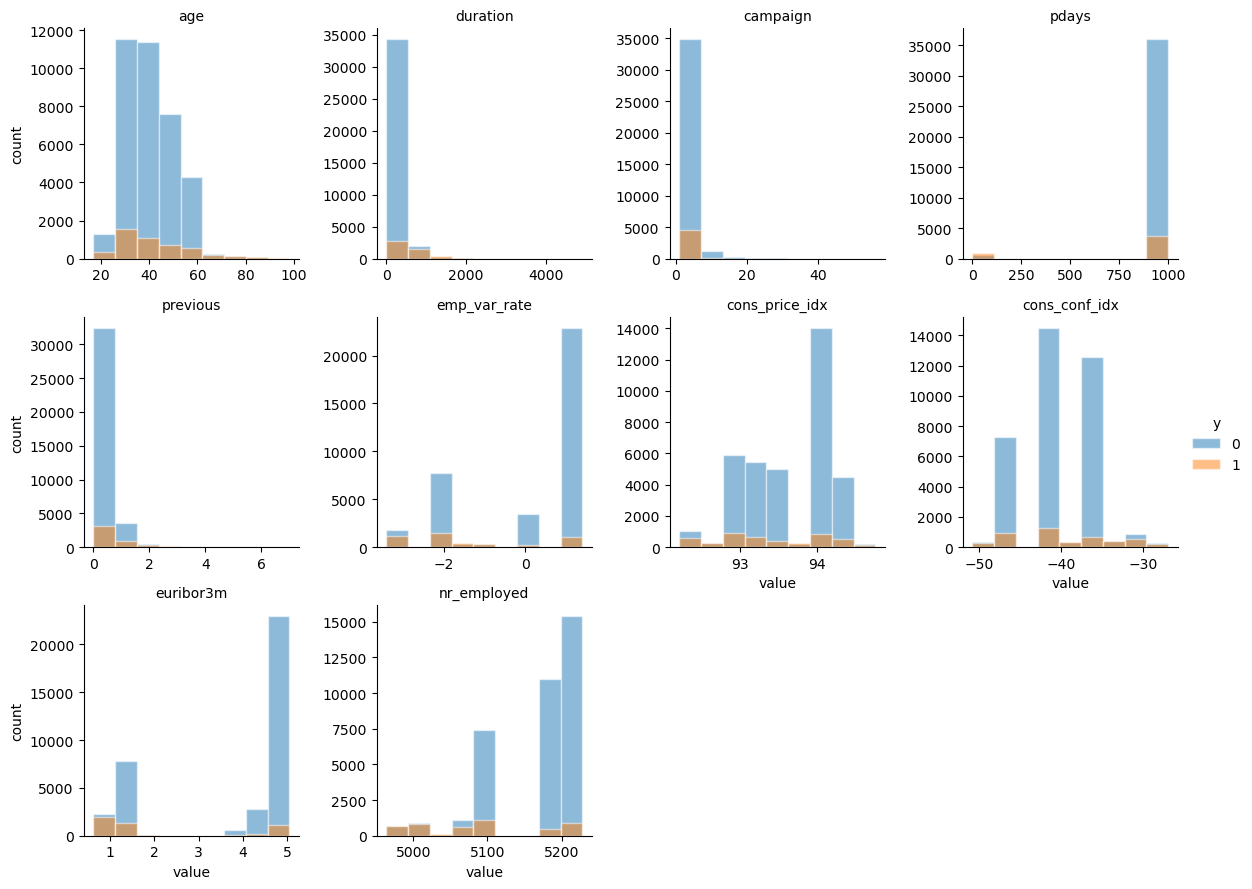

In [16]:
#this is the best iteration to get hist plot where all metrics has 10 bins

def multihist(x, hue, n_bins=10, color=None, **kws):
    bins = np.linspace(x.min(), x.max(), n_bins) 
    for _, x_i in x.groupby(hue):
        plt.hist(x_i, bins,label=_, **kws)

g=sns.FacetGrid(for_hist_plotting, col='variable', col_wrap=4, sharey=False, sharex=False)
g.map(multihist,  'value', 'y', alpha=.5, edgecolor="w")

g.set_ylabels('count')
g.add_legend(title='y')
g.set_titles("{col_name}")
;



In [17]:
#bucket continous data for cons_conf_idx
cons_conf_indx_condition=[
                        (df.cons_conf_idx <-50),
                        (df.cons_conf_idx >=-50 )& (df.cons_conf_idx < -40),
                        (df.cons_conf_idx >=-40) & (df.cons_conf_idx < -30),
                        (df.cons_conf_idx>=-30)
]

cons_conf_indx_labels=['under -50','between -50 and -40','between -40 and 30', 'above -30']

nr_employed_condition=[
                        (df.nr_employed <4950),
                        (df.nr_employed >=4950 )& (df.nr_employed <5050),
                        (df.nr_employed >=5050 )& (df.nr_employed <5150),
                        (df.nr_employed >=5150) & (df.nr_employed < 5250),
                        (df.cons_conf_idx>=5250)
]

nr_employed_labels=['<4950','between 4950 to 5050', 'between 5050 to 5150','between 5150 to 5250','above 5250']

#many candidate that has unknown pdays but may still contribute a strong correlation with label
p_days_condition =[ (df.pdays<=30),
                    (df.pdays>30)
]
p_days_labels=['<=30','unknown']


#most candidate has less than 3 campaigns
campaign_group=[
                    (df.campaign<=3),
                    (df.campaign>3)
]
campaign_labels =['<=3','>3']


#previous has only 8 unique value so i'm going to condense 0 and >0
previous_group=[
                    (df.previous==0),
                    (df.previous>0)
]
previous_labels=['0','>0']

#euribor3m has bimodal data split at 2.5 so i'll group them in half
euribor3m_group=[
                    (df.euribor3m<2.5),
                    (df.euribor3m>=2.5)
]
euribor3m_labels=['0','>0']

df=df.assign(
    cons_conf_indx_groups=np.select( cons_conf_indx_condition,cons_conf_indx_labels, default='None'),
    nr_employed_groups=np.select( nr_employed_condition,nr_employed_labels, default='None')    ,
    pdays_groups=np.select (p_days_condition,p_days_labels, default='None'),
    campaign_groups=np.select( campaign_group,campaign_labels, default='None'),
    previous_groups=np.select( previous_group,previous_labels, default='None'),
    euribor3m_groups=np.select( euribor3m_group,euribor3m_labels, default='None')
)


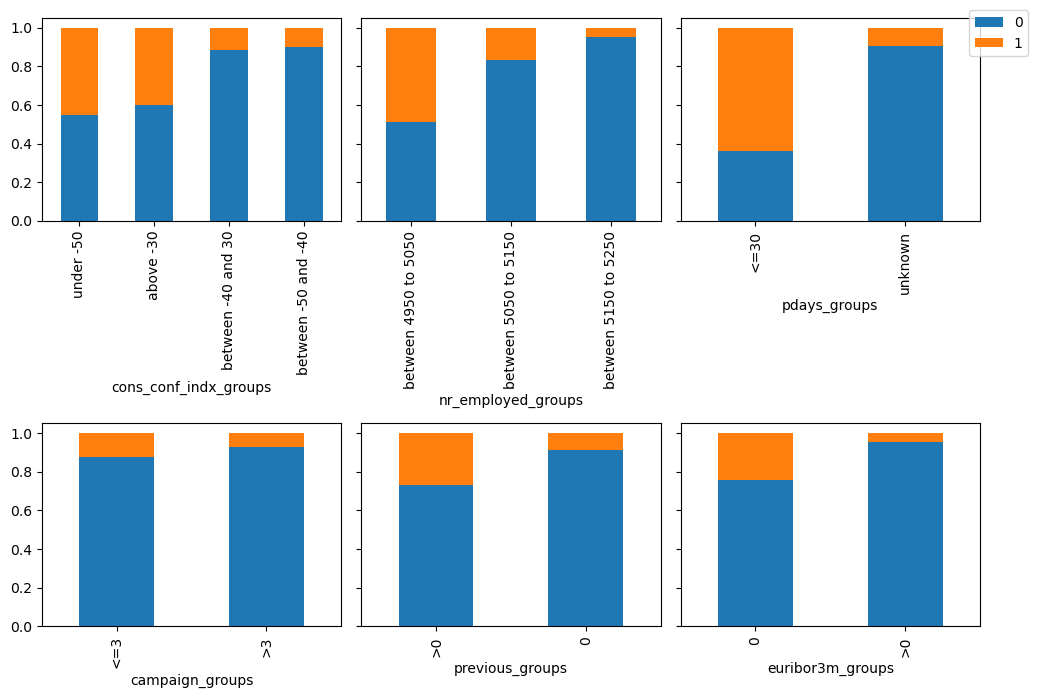

In [18]:
# check bar plot of new groups
bar_groups=['cons_conf_indx_groups','nr_employed_groups','pdays_groups','campaign_groups','previous_groups','euribor3m_groups']
fig,axes=plt.subplots(nrows=2, ncols=3, figsize=(10,7),sharex=False, sharey=True)
for i,ax in enumerate(fig.axes):

    pd.crosstab(df[bar_groups[i]],df.y, normalize='index').sort_values(by=1,ascending=False).plot.bar( stacked=True,ax=ax)
    ax.get_legend().remove()
    # or equivalently 
    #df.groupby(['y', 'job'])[['job']].count().unstack().fillna(0)
handles, labels= axes[0][0].get_legend_handles_labels()
fig.legend(handles,labels, bbox_to_anchor=(1.04,1))
plt.tight_layout()


#check correlations between independent variables (that are not grouped) separately for credit defaulters and non credit defaulters

/Users/faith/opt/anaconda3/lib/python3.9/site-packages/pandas/plotting/_matplotlib/misc.py:96: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


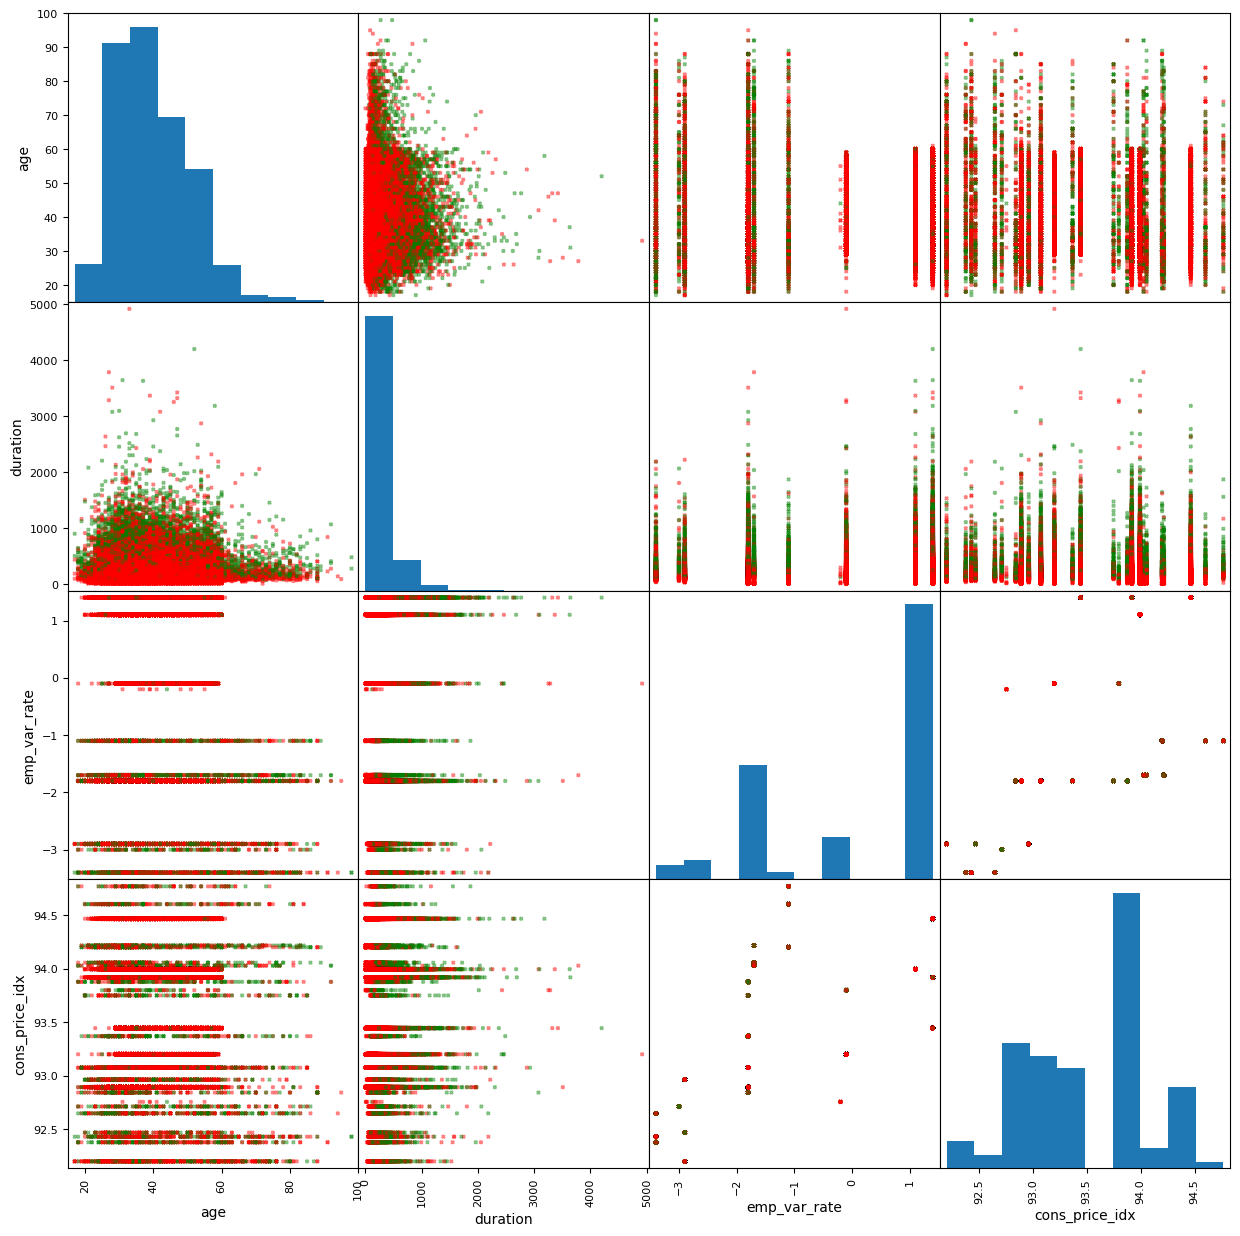

In [19]:
numerical_features=['age', 'duration', 'cons_price_idx' ,'emp_var_rate']
color_list = ['red' if i==0 else 'green' for i in df.loc[:,'y']]
pd.plotting.scatter_matrix(df.loc[:, (df.columns.isin(numerical_features))],
                                       c=color_list,
                                       figsize= [15,15],
                                       diagonal='hist',
                                       alpha=0.5,
                                       s = 5,
                                       marker = 'x',
                                       edgecolor= "black")
plt.show()

In [20]:
from scipy.stats import ks_2samp,ttest_ind
import numpy as np

In [21]:

numerical_summary=pd.DataFrame (index=numerical_features, columns=['mean_1','mean_0','ks p-value', 'ks decision', 't-p-value','t decision'])

for feat in numerical_features:

    #oompare the distribution of each outcome's metric to see if theyre significantly different 
    x1 = df.query('y==1')[feat].to_numpy() #subscribed
    x2 = df.query('y==0')[feat].to_numpy() # does not subscribe

    ksTestStatistic, pValue =ks_2samp(x1, x2)
    t_statistic, t_p_value = ttest_ind(x1, x2)

    text1 = "REJECT" if pValue< 0.05 else "ACCEPT"
    text2=  "REJECT" if t_p_value< 0.05 else "ACCEPT"

    numerical_summary.loc[feat,'mean_1']=np.round(x1.mean(),2)
    numerical_summary.loc[feat,'mean_0']=np.round(x2.mean(),2)

    numerical_summary.loc[feat,'ks p-value']=np.round(pValue,4)
    numerical_summary.loc[feat,'ks decision']=text1

    numerical_summary.loc[feat,'t-p-value']=np.round(t_p_value,4)
    numerical_summary.loc[feat,'t decision']=text2

    #print(f"The p-value is {chi_sq_result[1]:0.4f} and hence we {x} the null Hpothesis with {chi_sq_result[2]} degrees of freedom\n")
numerical_summary

,mean_1,mean_0,ks p-value,ks decision,t-p-value,t decision
age,40.91,39.91,0.0,REJECT,0.0,REJECT
duration,553.19,220.84,0.0,REJECT,0.0,REJECT
cons_price_idx,93.35,93.6,0.0,REJECT,0.0,REJECT
emp_var_rate,-1.23,0.25,0.0,REJECT,0.0,REJECT


# logistic regression

In [22]:
all_catg_features=cat_features2+bar_groups

#one hot encoding on categeorical variables
one_hot_encoded_catg=pd.get_dummies(df[all_catg_features], columns=all_catg_features, drop_first=True)
one_hot_encoded_catg

df_regress=one_hot_encoded_catg.merge(df.loc[:,numerical_features], left_index=True, right_index=True)
df_regress

,job_1_management,job_1_self_employed,job_1_services,job_1_unemployed,job_1_unknown,marital_married,marital_single,marital_unknown,education_1_illiterate,education_1_university,education_1_unknown,default_unknown,default_yes,loan_unknown,loan_yes,contact_telephone,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_nonexistent,poutcome_success,cons_conf_indx_groups_between -40 and 30,cons_conf_indx_groups_between -50 and -40,cons_conf_indx_groups_under -50,nr_employed_groups_between 5050 to 5150,nr_employed_groups_between 5150 to 5250,pdays_groups_unknown,campaign_groups_>3,previous_groups_>0,euribor3m_groups_>0,age,duration,cons_price_idx,emp_var_rate
0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,1,0,0,1,44,210,93.444,1.4
1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,1,53,138,93.200,-0.1
2,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,28,339,94.055,-1.7
3,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,1,0,0,0,39,185,93.075,-1.8
4,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,1,0,55,137,92.201,-2.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,1,0,0,1,59,222,94.465,1.4
41184,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,1,0,0,1,31,196,93.994,1.1
41185,1,0,0,0,0,0,1,0,0,1,0,1,0,0,1,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,1,0,0,1,42,62,93.994,1.1
41186,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,48,200,92.431,-3.4


In [46]:
# importing libraries 
import statsmodels.api as sm 
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


In [47]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_regress, df.y, test_size=0.2, random_state=42)


In [48]:

X_train = sm.add_constant(X_train)

scaler = StandardScaler()
X_train[numerical_features]= scaler.fit_transform(X_train[numerical_features])

In [49]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["feature"] = X_train.columns
vif_data["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(len(X_train.columns))]

# Print the VIF values
print(vif_data[vif_data['VIF']>5])
drop_high_vif=vif_data.loc[(vif_data['VIF']>5)]['feature'].values
# we should drop columns having greater than 5 VIF
X_train=X_train.drop(columns=drop_high_vif[1:])



/Users/faith/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/Users/faith/opt/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


                                      feature         VIF
17                                  month_aug   12.292728
19                                  month_jul   13.822069
20                                  month_jun    7.031594
22                                  month_may    5.616645
23                                  month_nov   46.260429
26                       poutcome_nonexistent         inf
27                           poutcome_success   10.535341
28   cons_conf_indx_groups_between -40 and 30  177.109471
29  cons_conf_indx_groups_between -50 and -40  272.264401
30            cons_conf_indx_groups_under -50   11.124677
31    nr_employed_groups_between 5050 to 5150   81.333182
32    nr_employed_groups_between 5150 to 5250         inf
33                       pdays_groups_unknown   11.075176
35                         previous_groups_>0         inf
36                        euribor3m_groups_>0         inf
39                             cons_price_idx   59.946213
40            

In [50]:
#Noticed some of high VIFs also corresponded to high correlation.  
#so we can drop all from high VIFs
drop_high_vif

array(['month_aug', 'month_jul', 'month_jun', 'month_may', 'month_nov',
       'poutcome_nonexistent', 'poutcome_success',
       'cons_conf_indx_groups_between -40 and 30',
       'cons_conf_indx_groups_between -50 and -40',
       'cons_conf_indx_groups_under -50',
       'nr_employed_groups_between 5050 to 5150',
       'nr_employed_groups_between 5150 to 5250', 'pdays_groups_unknown',
       'previous_groups_>0', 'euribor3m_groups_>0', 'cons_price_idx',
       'emp_var_rate'], dtype=object)

In [51]:
# Correlation matrix
corr_matrix = X_train.corr()

upper_corr_matrix=np.triu(corr_matrix, k=1)
upper_corr_matrix_df=pd.DataFrame(
    data=upper_corr_matrix,
    index=corr_matrix.index,
    columns=corr_matrix.columns
)
upper_corr_matrix_df


,const,job_1_management,job_1_self_employed,job_1_services,job_1_unemployed,job_1_unknown,marital_married,marital_single,marital_unknown,education_1_illiterate,education_1_university,education_1_unknown,default_unknown,default_yes,loan_unknown,loan_yes,contact_telephone,month_aug,month_dec,month_mar,month_oct,month_sep,campaign_groups_>3,age,duration
const,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
job_1_management,0.0,0.0,-0.132771,-0.257153,-0.213741,-0.145686,-0.076346,0.072042,-0.010235,-0.014285,0.279301,-0.052609,-0.129721,-0.006612,-0.008759,0.017793,-0.059979,0.057912,-0.001900,0.014903,-0.000368,0.009723,0.001622,-0.062300,-0.010806
job_1_self_employed,0.0,0.0,0.000000,-0.071115,-0.059110,-0.040289,0.051735,-0.063034,-0.004433,0.004017,0.033788,-0.000603,-0.003333,-0.001828,0.005347,-0.008075,0.019366,-0.052439,-0.013002,-0.019747,-0.012184,-0.006815,-0.003052,0.028276,0.004564
job_1_services,0.0,0.0,0.000000,0.000000,-0.114484,-0.078033,0.002378,-0.022434,0.001332,-0.003137,-0.231348,-0.003991,0.030359,-0.003541,0.006038,-0.000711,0.036933,-0.052971,-0.010029,-0.022100,-0.018651,-0.016903,0.003093,-0.018480,-0.007760
job_1_unemployed,0.0,0.0,0.000000,0.000000,0.000000,-0.064860,-0.041497,0.033217,0.011780,0.004097,-0.066797,0.061101,-0.002588,0.008349,0.000008,0.001408,-0.041538,0.004404,0.066810,0.056393,0.097574,0.089745,-0.015102,0.208199,0.018549
job_1_unknown,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.020763,-0.013030,0.029514,0.017606,0.064564,0.053303,0.019381,-0.002006,0.005245,-0.005103,0.009866,0.004969,-0.000877,0.002473,-0.001561,0.002762,0.007966,0.021616,0.003617
marital_married,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,-0.773355,-0.053192,0.010670,-0.098129,0.007397,0.130544,0.007726,-0.005387,-0.001615,0.064058,0.037689,0.003483,-0.045623,-0.011046,-0.007196,-0.005693,0.274630,-0.005270
marital_single,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.026966,-0.009635,0.100541,-0.003553,-0.121974,-0.005975,0.002561,0.004795,-0.069259,-0.023972,-0.001526,0.048769,0.016216,0.013073,-0.005975,-0.413530,0.008337
marital_unknown,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000888,0.002941,0.022773,-0.004718,-0.000411,-0.002327,0.001512,-0.001875,-0.008204,-0.002922,0.007079,0.005395,-0.005045,0.004902,0.007727,0.013515
education_1_illiterate,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.017734,-0.004304,0.011173,-0.000197,-0.003287,0.003620,-0.009521,0.003713,-0.001399,-0.002429,-0.002689,-0.002415,-0.002251,0.017575,0.004989


In [52]:
# Melt the DataFrame to a tidy format
tidy_corr_df = (
    upper_corr_matrix_df
    .stack()  # Reshape to long format
    .reset_index()  # Reset the index to get feature names
    .rename(columns={0: 'Correlation', 'level_0': 'Feature 1', 'level_1': 'Feature 2'})  # Rename columns
)

# Filter for non-zero correlations (remove those we excluded with np.triu)
tidy_corr_df = tidy_corr_df[tidy_corr_df['Correlation'] != 0].reset_index(drop=True)

# Sort by absolute correlation value for easier analysis
tidy_corr_df = tidy_corr_df.sort_values(by='Correlation', key=abs, ascending=False)
tidy_corr_df


,Feature 1,Feature 2,Correlation
105,marital_married,marital_single,-0.773355
138,marital_single,age,-0.413530
240,contact_telephone,month_aug,-0.280492
8,job_1_management,education_1_university,0.279301
121,marital_married,age,0.274630
1,job_1_management,job_1_services,-0.257153
51,job_1_services,education_1_university,-0.231348
2,job_1_management,job_1_unemployed,-0.213741
84,job_1_unemployed,age,0.208199
177,education_1_university,month_aug,0.188160


In [53]:
   
# building the model and fitting the data 
log_reg = sm.Logit(y_train, X_train).fit()
log_reg.summary()

         Current function value: 0.249439
         Iterations: 35


/Users/faith/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                32950
Model:                          Logit   Df Residuals:                    32925
Method:                           MLE   Df Model:                           24
Date:                Sun, 15 Dec 2024   Pseudo R-squ.:                  0.2895
Time:                        22:41:08   Log-Likelihood:                -8219.0
converged:                      False   LL-Null:                       -11568.
Covariance Type:            nonrobust   LLR p-value:                     0.000
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -2.6200      0.079    -33.193      0.000      -2.775      -2.465
job_1_management           0.2851      0.052      5.510      0.000       0.184       0.386
job_1_self_employed       -0.0008      0.126     -0.006      0.995      -0.247       0.246
job_1_services             0.1350      0.076      1.780      0.075      -0.014       0.284
job_1_unemployed           0.8840      0.070     12.695      0.000       0.747       1.020
job_1_unknown              0.0916      0.111      0.823      0.411      -0.127       0.310
marital_married            0.0808      0.070      1.156      0.248      -0.056       0.218
marital_single             0.3536      0.079      4.498      0.000       0.200       0.508
marital_unknown           -0.3449      0.487     -0.708      0.479      -1.300       0.610
education_1_illiterate     0.9906      0.761      1.301      0.193      -0.501       2.483
education_1_university     0.2396      0.046      5.165      0.000       0.149       0.331
education_1_unknown        0.3354      0.100      3.362      0.001       0.140       0.531
default_unknown           -0.8606      0.069    -12.402      0.000      -0.997      -0.725
default_yes              -26.9591   1.62e+06  -1.66e-05      1.000   -3.18e+06    3.18e+06
loan_unknown              -0.0115      0.137     -0.084      0.933      -0.281       0.258
loan_yes                  -0.1111      0.059     -1.876      0.061      -0.227       0.005
contact_telephone         -1.0729      0.054    -19.691      0.000      -1.180      -0.966
month_aug                 -0.1132      0.061     -1.846      0.065      -0.233       0.007
month_dec                  1.8121      0.187      9.683      0.000       1.445       2.179
month_mar                  2.2533      0.106     21.196      0.000       2.045       2.462
month_oct                  1.8377      0.102     18.000      0.000       1.638       2.038
month_sep                  1.7433      0.112     15.622      0.000       1.525       1.962
campaign_groups_>3        -0.3756      0.062     -6.018      0.000      -0.498      -0.253
age                        0.0970      0.022      4.456      0.000       0.054       0.140
duration                   1.0912      0.019     56.889      0.000       1.054       1.129
==========================================================================================
"""


## Observations
### Significant Predictors:

1. job_1_management: Positive effect on the log-odds of y (p < 0.001).
2. marital_single: Significant positive effect (p < 0.001).
3. education_1_university: Positive association (p < 0.001).
4. default_unknown: Significant negative association (p < 0.001).
5. duration: Strong positive effect (p < 0.001).
6. campaign_groups_>3: Significant negative effect (p < 0.001).

### Non-significant Predictors:

1. job_1_self_employed: Coefficient very close to 0 and not statistically significant (p = 1.000).
2. loan_unknown and loan_yes: Not significant at the 0.05 level.


### Noteworthy Points:

default_yes: The coefficient is extremely large in magnitude, which may be due to sparse data or a quasi-complete separation issue. Consider investigating the data distribution for this variable.
Duration has a very high z-value and is overwhelmingly significant. This suggests it strongly drives the outcome, but it might overshadow other predictors.

In [54]:
# predict test set
X_test = sm.add_constant(X_test)

# scaler = StandardScaler()
X_test[numerical_features]= scaler.fit_transform(X_test[numerical_features])
X_test=X_test.drop(columns=drop_high_vif[1:])
y_pred=log_reg.predict(X_test)

# Convert probabilities to binary predictions
threshold = 0.5
y_pred_class = (y_pred >= threshold).astype(int)


In [55]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score

# Evaluate the predictions
accuracy = accuracy_score(y_test, y_pred_class)
precision = precision_score(y_test, y_pred_class)
recall = recall_score(y_test, y_pred_class)
roc_auc = roc_auc_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"ROC-AUC: {roc_auc:.2f}")

Accuracy: 0.90
Precision: 0.60
Recall: 0.26
ROC-AUC: 0.89
